In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random
import time
from tqdm import tqdm
from matplotlib import pyplot as plt

In [24]:
df = pd.read_csv("../data/data.csv", converters={#'valid_years_days_dict': eval, 
                                                 'valid_day_list':eval})
df.head()

,weekday_name,month,leap_year_condition,decade,output,output_year_digit,output_year,output_day,valid_years_days_dict,valid_years_list,valid_day_list
0,2,1,0,180,1-1-1800,0,1800,1,"{0: [1, 8, 15, 22, 29], 1: [7, 14, 21, 28], 2:...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]"
1,3,1,0,180,1-1-1801,1,1801,1,"{0: [2, 9, 16, 23, 30], 1: [1, 8, 15, 22, 29],...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]"
2,4,1,0,180,1-1-1802,2,1802,1,"{0: [3, 10, 17, 24, 31], 1: [2, 9, 16, 23, 30]...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]"
3,5,1,0,180,1-1-1803,3,1803,1,"{0: [4, 11, 18, 25], 1: [3, 10, 17, 24, 31], 2...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]"
4,6,1,1,180,1-1-1804,4,1804,1,"{4: [1, 8, 15, 22, 29], 8: [3, 10, 17, 24, 31]}","[4, 8, 4, 4, 4, 4, 4, 4]","[1, 8, 15, 22, 29]"


In [25]:
x_day = df[["weekday_name", "month", "output_year", "output_day", "valid_day_list"]]
y_day = x_day.pop("output_day")
v = x_day.pop("valid_day_list")
v = pd.DataFrame([i for i in v])
# v.head(), x_day.head()

**A- training for getting the year**

In [26]:
# fix random number generation aka regenerate the same random numbers every time (such as weight and bias initialization )
def set_random_seed(seed=7, deterministic=True):
    """Set random seed, for python, numpy, pytorch

    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for
            CUDNN backend, i.e., set `torch.backends.cudnn.deterministic`
            to True and `torch.backends.cudnn.benchmark` to False.
            Default: True.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False 
seed=7        
set_random_seed(seed=seed)

In [27]:
batch_size = 64
xtrain_day, xtest_day, ytrain_day, ytest_day, vtrain_day, vtest_day = train_test_split(x_day, y_day, v, test_size=0.19, shuffle=True, random_state=seed)

In [28]:
class CollectedData(Dataset):
    def __init__(self, x, y, v):
        self.data = torch.tensor(x.values.astype(np.float32))
        self.label = torch.tensor(y.values)
        self.valids = torch.tensor(v.values.astype(np.int8))
        self.n_smpl = x.shape[0]
        
        
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx], self.valids[idx]
    
    def __len__(self):
        return self.n_smpl    
    
train_set_day = CollectedData(xtrain_day, ytrain_day, vtrain_day)
test_set_day = CollectedData(xtest_day, ytest_day, vtest_day)    

In [29]:
# # this isn't suitable here, so that i used train_test_split function
# # train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-test_len, int(len(dataset)*0.2)])

# train_labels_day = torch.tensor(ytrain_day.values.astype(np.float32)) 
# test_labels_day = torch.tensor(ytest_day.values.astype(np.float32)) 
# train_input_day = torch.tensor(xtrain_day.values.astype(np.float32)) 
# test_input_day = torch.tensor(xtest_day.values.astype(np.float32)) 

# train_set_day = TensorDataset(train_input_day, train_labels_day)
# test_set_day = TensorDataset(test_input_day, test_labels_day)


In [30]:
train_loader_day = DataLoader(dataset=train_set_day, shuffle=True, batch_size=batch_size)
# test_loader_day = DataLoader(dataset=test_set_day, batch_size=batch_size) 

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class network(nn.Module):
    def __init__(self, in_features=3, out_features=31):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 31)
        self.fc2 = nn.Linear(31, 31)
        self.fc3 = nn.Linear(31, 31)
        self.fc4 = nn.Linear(31, out_features) 
        self.initialize_weights()
        
        
    def forward(self, inpt):
        out = F.leaky_relu(self.fc1(inpt))
        out = F.leaky_relu(self.fc2(out))
        out = F.leaky_relu(self.fc3(out))
        out = ((self.fc4(out)))#nn.Softmax
        return out
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

In [32]:
# calculating accuracy
@torch.no_grad()
def calculate_accuracy(model, data_loader=train_loader_day):
    model.eval()
    
    num_correct = 0
    num_samples = 0

    for data, labels, valids in data_loader:
        
        # transfering data to cuda
        data = data.to(device=device)
        valids = valids.to(device=device)
                
        preds = model(data)
        num_correct += len([1 for pred, vald in zip(preds.argmax(dim=1), valids) if pred in vald])
        num_samples += len(preds)
    accuracy = num_correct/num_samples
    model.train()
    return accuracy  

In [33]:
# initializing the network
model = network(in_features=3, out_features=31).to(device)
lr = 0.01
# loss and optimizer initializing
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.00001, patience=3, verbose=True)

In [34]:
num_epochs = 31
def train_model(num_epochs, data_loader=train_loader_day):
    num_batches = len(data_loader)
    print(f"starting learning rate = {lr} \n number of epochs = {num_epochs} \n number of batches = {num_batches} \n")
    # starting training loop epochs
    result_train_acc, result_test_acc = [], []
    for epoch in range(num_epochs):
        start_time = time.time()
        progress = tqdm(enumerate(data_loader), total=num_batches, leave=True)
        for batch_idx, (data, labels, valids) in progress: 

            # convert data to device
            data = data.to(device=device)
            labels = labels.to(device=device)
            valids = valids.to(device=device)

            # getting prediction and loss
            preds = model(data)
            loss = criterion(preds, labels)        

            # back propagation
            optimizer.zero_grad()
            loss.backward()

            # optimization step
            optimizer.step()

            progress.set_description(f"epoch [{1+epoch}/{num_epochs}], loss={loss.item():0.4f}")
            progress.set_postfix()

        train_acc = calculate_accuracy(model, data_loader=train_loader_day)
        test_acc = calculate_accuracy(model, data_loader=test_loader_day)
        schedular.step(test_acc)
        print(f"after {1+epoch} epoch, train_acc = {(train_acc*100):.2f}%, test_acc = {(test_acc*100):.2f}%, time_elapsed = {((time.time()-start_time)/60):.1f} minuts")
        result_train_acc += [train_acc]
        result_test_acc += [test_acc]
    return result_train_acc, result_test_acc
result_train_acc, result_test_acc = train_model(num_epochs, data_loader=train_loader_day)


starting learning rate = 0.01 
 number of epochs = 31 
 number of batches = 1854 



epoch [1/31], loss=1.9980: 100%|███████████████████████████████████████████████████| 1854/1854 [00:24<00:00, 75.41it/s]


after 1 epoch, train_acc = 16.28%, test_acc = 15.96%, time_elapsed = 1.1 minuts


epoch [2/31], loss=1.6646: 100%|███████████████████████████████████████████████████| 1854/1854 [00:19<00:00, 96.06it/s]


after 2 epoch, train_acc = 16.28%, test_acc = 15.96%, time_elapsed = 1.2 minuts


epoch [3/31], loss=2.1773: 100%|███████████████████████████████████████████████████| 1854/1854 [00:25<00:00, 72.96it/s]


after 3 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.3 minuts


epoch [4/31], loss=1.2796: 100%|███████████████████████████████████████████████████| 1854/1854 [00:25<00:00, 73.56it/s]


after 4 epoch, train_acc = 16.28%, test_acc = 15.96%, time_elapsed = 1.3 minuts


epoch [5/31], loss=1.6107: 100%|███████████████████████████████████████████████████| 1854/1854 [00:22<00:00, 82.48it/s]


after 5 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.3 minuts


epoch [6/31], loss=1.7630: 100%|███████████████████████████████████████████████████| 1854/1854 [00:22<00:00, 81.54it/s]


after 6 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.3 minuts


epoch [7/31], loss=2.0321: 100%|███████████████████████████████████████████████████| 1854/1854 [00:23<00:00, 79.42it/s]


Epoch 00007: reducing learning rate of group 0 to 1.0000e-07.
after 7 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.4 minuts


epoch [8/31], loss=1.6778: 100%|███████████████████████████████████████████████████| 1854/1854 [00:26<00:00, 69.38it/s]


after 8 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.3 minuts


epoch [9/31], loss=2.1370: 100%|███████████████████████████████████████████████████| 1854/1854 [00:23<00:00, 80.37it/s]


after 9 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.5 minuts


epoch [10/31], loss=1.8490: 100%|██████████████████████████████████████████████████| 1854/1854 [00:26<00:00, 69.61it/s]


after 10 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.3 minuts


epoch [11/31], loss=1.8732: 100%|██████████████████████████████████████████████████| 1854/1854 [00:18<00:00, 97.64it/s]


Epoch 00011: reducing learning rate of group 0 to 1.0000e-12.
after 11 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.2 minuts


epoch [12/31], loss=1.6599: 100%|█████████████████████████████████████████████████| 1854/1854 [00:15<00:00, 119.26it/s]


after 12 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.0 minuts


epoch [13/31], loss=2.1385: 100%|█████████████████████████████████████████████████| 1854/1854 [00:15<00:00, 119.65it/s]


after 13 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.0 minuts


epoch [14/31], loss=1.8473: 100%|█████████████████████████████████████████████████| 1854/1854 [00:15<00:00, 118.31it/s]


after 14 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.0 minuts


epoch [15/31], loss=1.8756: 100%|█████████████████████████████████████████████████| 1854/1854 [00:15<00:00, 119.73it/s]


after 15 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.1 minuts


epoch [16/31], loss=1.9174: 100%|██████████████████████████████████████████████████| 1854/1854 [00:18<00:00, 97.65it/s]


after 16 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.2 minuts


epoch [17/31], loss=1.8796: 100%|█████████████████████████████████████████████████| 1854/1854 [00:15<00:00, 118.74it/s]


after 17 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.0 minuts


epoch [18/31], loss=1.8700: 100%|█████████████████████████████████████████████████| 1854/1854 [00:15<00:00, 119.03it/s]


after 18 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.0 minuts


epoch [19/31], loss=2.1414: 100%|█████████████████████████████████████████████████| 1854/1854 [00:15<00:00, 120.89it/s]


after 19 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.1 minuts


epoch [20/31], loss=1.4675: 100%|█████████████████████████████████████████████████| 1854/1854 [00:18<00:00, 102.18it/s]


after 20 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.2 minuts


epoch [21/31], loss=1.5326: 100%|█████████████████████████████████████████████████| 1854/1854 [00:18<00:00, 102.82it/s]


after 21 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.2 minuts


epoch [22/31], loss=1.8359: 100%|█████████████████████████████████████████████████| 1854/1854 [00:16<00:00, 114.91it/s]


after 22 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.0 minuts


epoch [23/31], loss=1.6974: 100%|█████████████████████████████████████████████████| 1854/1854 [00:15<00:00, 119.40it/s]


after 23 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.0 minuts


epoch [24/31], loss=1.7787: 100%|█████████████████████████████████████████████████| 1854/1854 [00:15<00:00, 116.39it/s]


after 24 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.1 minuts


epoch [25/31], loss=1.8599: 100%|█████████████████████████████████████████████████| 1854/1854 [00:18<00:00, 102.01it/s]


after 25 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.2 minuts


epoch [26/31], loss=2.0758: 100%|█████████████████████████████████████████████████| 1854/1854 [00:18<00:00, 101.33it/s]


after 26 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.2 minuts


epoch [27/31], loss=1.6894: 100%|█████████████████████████████████████████████████| 1854/1854 [00:15<00:00, 119.81it/s]


after 27 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.0 minuts


epoch [28/31], loss=1.9854: 100%|█████████████████████████████████████████████████| 1854/1854 [00:15<00:00, 119.65it/s]


after 28 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.0 minuts


epoch [29/31], loss=1.6134: 100%|█████████████████████████████████████████████████| 1854/1854 [00:17<00:00, 103.37it/s]


after 29 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.2 minuts


epoch [30/31], loss=1.7622: 100%|█████████████████████████████████████████████████| 1854/1854 [00:18<00:00, 101.12it/s]


after 30 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.2 minuts


epoch [31/31], loss=1.6708: 100%|█████████████████████████████████████████████████| 1854/1854 [00:18<00:00, 101.94it/s]


after 31 epoch, train_acc = 16.21%, test_acc = 15.92%, time_elapsed = 1.2 minuts


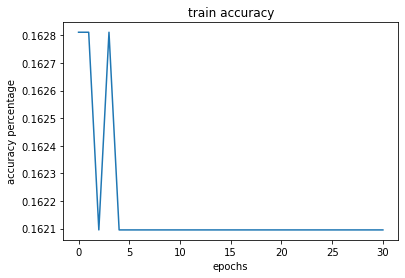

In [35]:
plt.plot(list(range(num_epochs)), result_train_acc)
plt.title("train accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy percentage")
plt.show()

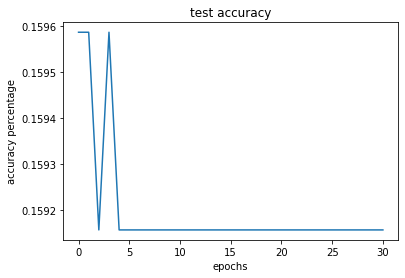

In [36]:
plt.plot(list(range(num_epochs)), result_test_acc)
plt.title("test accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy percentage")
plt.show()

In [37]:
d_test = xtest_day
dt = d_test.copy(deep=True)
d_test = torch.tensor(d_test.values.astype(np.float32))
preds = model(d_test.to(device=device)).argmax(dim=1).cpu()
dt["predicted_day"] = preds
dt

,weekday_name,month,output_year,predicted_day
100361,1,11,1911,2
99263,6,8,2016,2
6673,2,5,2057,2
127052,6,5,2136,2
62177,4,12,1822,2
...,...,...,...,...
9395,5,12,1972,2
69251,0,5,2079,2
33138,1,11,2056,2
136452,3,6,1815,2


In [38]:
dt.to_csv("../data/day_predections.csv", header=True, index=True)